<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/npr-working/brazil-ood-evals-for-paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isoscape Evals

Notebook Purpose: Eval isoscape generation methods for our paper

Isoscape Task: Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil.

# Setup

## Fetch Dependencies

In [1]:
!pip install rasterio fiona pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 902.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 13.6 MB/s eta 0:00:00


### If Doing Monte-Carlo: PyMC3 is not packaged properly. Install that.

In [ ]:
!pip install mkl-service versioneer

In [ ]:
!git clone https://github.com/pymc-devs/pymc3
!cd pymc3 && pip install -r requirements.txt

In [ ]:
!cd pymc3 && python setup.py install

In [ ]:
!rm -rf pymc3

## Import libraries required

In [2]:
import importlib
from datetime import datetime
import sys
import os

In [3]:
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 7.36 KiB | 7.36 MiB/s, done.
Resolving deltas: 100% (7/7), done.
executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


In [5]:
import train_variational_inference_model as tvim
import raster
import eeddf
import dataset
import fiona
import rasterio.mask
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount(raster.GDRIVE_BASE)

# Leave test_environment=True. Experiments must be done in test.
eeddf.initialize_ddf(test_environment=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Patch https://github.com/tnc-br/ddf_common/issues/72 here
import evaluation
importlib.reload(evaluation)
importlib.reload(tvim)

<module 'train_variational_inference_model' from '/tmp/ddf_common/train_variational_inference_model.py'>

# Data configuration

In [7]:
# REQUIREMENTS:

# 1) Column names must match features_to_standardize, features_to_passthrough
# 2) Label columns in particular must match var_label and mean_label.
#
# If you used the data ingestion notebook (ingestion.ipynb) then this
# should be set up for you already.

# TRAINING FILE PARAMS
DATABASE_DIR = raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE
TRAINING_SET_FILE = 'canonical/uc_davis_train_fixed_grouped.csv' #@param
VALIDATION_SET_FILE = 'canonical/uc_davis_validation_fixed_grouped.csv' #@param
TEST_SET_FILE = 'canonical/uc_davis_test_fixed_grouped.csv' #@param

# EVAL FILE PARAMS
EVAL_DATASET = 'canonical/uc_davis_test_fixed_grouped.csv' #@param
#ORIGINAL_DATASET = 'canonical/2023_07_27_Results_google_utf8_latlonadded.csv' #@param
ORIGINAL_DATASET = 'canonical/2023_06_23_Results_Google.csv' #@param


fileset = {
    'TRAIN' : os.path.join(DATABASE_DIR, TRAINING_SET_FILE),
    'TEST' : os.path.join(DATABASE_DIR, VALIDATION_SET_FILE),
    'VALIDATION' : os.path.join(DATABASE_DIR, TEST_SET_FILE),
    'EVAL' : os.path.join(DATABASE_DIR, EVAL_DATASET),
    'ORIGINAL' : os.path.join(DATABASE_DIR, ORIGINAL_DATASET)
}

def prepare_dataset(params: tvim.VIModelTrainingParams, files: dict) -> dataset.ScaledPartitions:
  # Prepared columns not in the original input-- these are engineered features
  # that we believe include strong signals, stored as geotiffs
  potentially_extra_columns = [
      "brisoscape_mean_ISORIX",
      "d13C_cel_mean",
      "d13C_cel_var",
      "ordinary_kriging_linear_d18O_predicted_mean",
      "ordinary_kriging_linear_d18O_predicted_variance",
  ]

  #Load the geotiff it the params request it.
  extra_columns_from_geotiffs = {}
  for feature in params.features_to_passthrough + params.features_to_standardize:
      if feature in potentially_extra_columns:
          extra_columns_from_geotiffs[feature] = raster.column_name_to_geotiff_fn[feature]()

  return dataset.load_and_scale(
      files,
      params.mean_label,
      params.var_label,
      params.features_to_passthrough,
      [],
      params.features_to_standardize,
      extra_columns_from_geotiffs)

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/bra_adm_ibge_2020_shp.zip') as shp:
  BRAZIL_SHP_MASK = [feature["geometry"] for feature in shp]

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/Amazon Biome.zip/data/commondata/data0') as shp:
  AMAZON_SHP_MASK = [feature["geometry"] for feature in shp]

# Load these lazily later from the first generated isoscapes

def display_brazil(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, BRAZIL_SHP_MASK, crop=False)
    out_meta = src.meta
    brazil_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, brazil_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

def display_amazon(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, AMAZON_SHP_MASK, crop=False)
    out_meta = src.meta
    amazon_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, amazon_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

# Non-VI Models

## Ordinary Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/00_ordinary.html

In [8]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [17]:
params = tvim.VIModelTrainingParams(
    training_id = "test-okrige-2025-01-31-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ordinary_kriging", "all_standardized", "gaussian_variogram", "rev5"], #@param
    n_cv_folds=None,
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [22]:
data = prepare_dataset(params, fileset)

In [23]:
import pandas as pd
import numpy as np
import raster
import generate_isoscape
from sklearn.metrics import mean_squared_error

raw_train = pd.read_csv(fileset['TRAIN'])

In [24]:
def run_ordinary_kriging(**kwargs):
  # Not enough data to properly fit a Gaussian variogram
  ok = OrdinaryKriging(data.train.X['lat'], data.train.X['long'], data.train.Y['d18O_cel_mean'], **kwargs)

  min_long = min(data.train.X['long'])
  max_long = max(data.train.X['long'])
  min_lat = min(data.train.X['lat'])
  max_lat = max(data.train.X['lat'])

  # Predict the isotope values on the range of lattitude and longitude values
  # within the bounds of our VPD geotiff (should be Brazil-shaped), then save
  # for qualitative eval / display
  isoscape_long_values =  np.linspace(min_long, max_long, params.resolution_x)
  isoscape_lat_values = np.linspace(min_lat, max_lat, params.resolution_y)

  means, variances  = ok.execute("grid", isoscape_long_values,
                                  isoscape_lat_values)
  ok.print_statistics()

  arbitrary_geotiff = raster.vapor_pressure_deficit_geotiff()
  base_bounds = raster.get_extent(arbitrary_geotiff.gdal_dataset)
  final_bounds = raster.create_bounds_from_res(params.resolution_x, params.resolution_y, base_bounds)

  all_predictions = np.ma.masked_array([means, variances], mask=[np.isnan(means), np.isnan(variances)]) # raster, lat, lon
  all_predictions = np.transpose(all_predictions, axes=[1, 2, 0]) # lat, lon, raster

  generate_isoscape.save_numpy_to_geotiff(final_bounds, all_predictions, ISOSCAPE_SAVE_LOCATION)

  # Quantitative Eval Metrics
  test_pred_means, test_pred_vars  = ok.execute("points", data.test.X['long'],
                                  data.test.X['lat'])
  test_ground_means = data.test.Y[params.mean_label]
  test_ground_vars = data.test.Y[params.var_label]
  print(f'Means RMSE: {np.sqrt(mean_squared_error(test_ground_means, test_pred_means))}')
  print(f'Variances RMSE: {np.sqrt(mean_squared_error(test_ground_vars, test_pred_vars))}')



In [25]:
# Not enough data for a gaussian variogram (we only use the 'train' split)
run_ordinary_kriging(variogram_model='gaussian')

Q1 = None
Q2 = None
cR = None
Means RMSE: 1.6616757691130193
Variances RMSE: 8.109249988594865


In [ ]:
display_brazil(0) # Means

In [ ]:
display_amazon(0) # Means

In [28]:
EVAL_ONLY = True
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


In [29]:
params.tags

['author:npr',
 'ordinary_kriging',
 'all_standardized',
 'gaussian_variogram',
 'rev5']

## Universal Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/01_universal.html

In [37]:
params = tvim.VIModelTrainingParams(
    training_id = "test-ukrige-2025-01-31-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "universal_kriging", "all_standardized", "linear_variogram", "rev3"], #@param
    n_cv_folds=None,
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [38]:
data = prepare_dataset(params, fileset)

In [39]:
import pandas as pd
import numpy as np
import raster
import pykrige.kriging_tools as kt
from pykrige.uk import UniversalKriging
from sklearn.metrics import mean_squared_error
raw_train = pd.read_csv(fileset['TRAIN'])

In [40]:
def run_universal_kriging(**kwargs):
  uk = UniversalKriging(data.train.X['lat'], data.train.X['long'], data.train.Y['d18O_cel_mean'], **kwargs)
  min_long = min(data.train.X['long'])
  max_long = max(data.train.X['long'])
  min_lat = min(data.train.X['lat'])
  max_lat = max(data.train.X['lat'])

  # Predict the isotope values on the range of lattitude and longitude values
  # within the bounds of our VPD geotiff (should be Brazil-shaped), then save
  # for qualitative eval / display
  isoscape_long_values =  np.linspace(min_long, max_long, params.resolution_x)
  isoscape_lat_values = np.linspace(min_lat, max_lat, params.resolution_y)
  means, variances  = uk.execute("grid", isoscape_long_values,
                                  isoscape_lat_values)
  uk.print_statistics()

  arbitrary_geotiff = raster.vapor_pressure_deficit_geotiff()
  base_bounds = raster.get_extent(arbitrary_geotiff.gdal_dataset)
  final_bounds = raster.create_bounds_from_res(params.resolution_x, params.resolution_y, base_bounds)

  all_predictions = np.ma.masked_array([means, variances], mask=[np.isnan(means), np.isnan(variances)]) # raster, lat, lon
  all_predictions = np.transpose(all_predictions, axes=[1, 2, 0]) # lat, lon, raster

  generate_isoscape.save_numpy_to_geotiff(final_bounds, all_predictions, ISOSCAPE_SAVE_LOCATION)

  # Quantitative Eval Metrics
  test_pred_means, test_pred_vars  = uk.execute("points", data.test.X['long'],
                                  data.test.X['lat'])
  test_ground_means = data.test.Y[params.mean_label]
  test_ground_vars = data.test.Y[params.var_label]
  print(f'Means RMSE: {np.sqrt(mean_squared_error(test_ground_means, test_pred_means))}')
  print(f'Variances RMSE: {np.sqrt(mean_squared_error(test_ground_vars, test_pred_vars))}')


In [41]:
run_universal_kriging(variogram_model='linear', drift_terms=['regional_linear'])

Q1 = 0.7151932816470236
Q2 = 1.6623374194545486
cR = 1.9228636927560991
Means RMSE: 1.2233162221816973
Variances RMSE: 7.890280099543764


In [ ]:
display_brazil(0)

In [42]:
EVAL_ONLY = True
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


## Regression Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/07_regression_kriging2d.html

In [49]:
params = tvim.VIModelTrainingParams(
    training_id = "test-rkrige-2025-01-31-2", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = ['lat', 'long'], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "regression_kriging", "all_standardized", "rev2", "krige_type:regression", "variogram:gaussian", "n_estimators:100", "max_depth:20", "regression_strategy:gradientboosting"], #@param
    n_cv_folds = None
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")

In [50]:
import pandas as pd
import numpy as np
import raster
from numpy.typing import NDArray
from typing import Tuple, List

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import generate_isoscape
import model

from pykrige.rk import RegressionKriging


def run_regression_kriging(regression_model, regression_kwargs, krige_kwargs):
  data = prepare_dataset(params, fileset)
  raw_train = pd.read_csv(fileset['TRAIN']).dropna()
  raw_val = pd.read_csv(fileset['VALIDATION']).dropna()

  svr_model = SVR(C=0.1, gamma="auto")
  rf_model = RandomForestRegressor(n_estimators=1000)
  lr_model = LinearRegression(copy_X=True, fit_intercept=True)
  gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=20)

  models = [svr_model, rf_model, lr_model]

  train_features = params.features_to_standardize + params.features_to_passthrough
  train_features_nolatlon = list(train_features)
  train_features_nolatlon.remove('lat')
  train_features_nolatlon.remove('long')

  p_train = pd.concat((data.train.X[train_features_nolatlon], data.val.X[train_features_nolatlon],), join='inner')
  x_train = np.concatenate((np.array(tuple(zip(raw_train['lat'], raw_train['long']))), np.array(tuple(zip(raw_val['lat'], raw_val['long'])))))
  target_train = pd.concat((raw_train[params.mean_label], raw_val[params.mean_label],), join='inner')


  rk = RegressionKriging(regression_model=regression_model(**regression_kwargs), **krige_kwargs)
  # Why do I call .to_numpy() here?
  # to_numpy() removes feature names, which ColumnTransformer.transform() strips
  # in predict_on_batch(). If trained with feature names but inference is run
  # without, a long list of warnings will be printed and isoscape generation will
  # be slower.
  rk.fit(p_train.to_numpy(), x_train, target_train)


  class DDFRegressionKrigingModel(model.Model):
    # #@override
    def __init__(self, rk: RegressionKriging, training_cols: List[str]):
      self.rk = rk
      self.training_cols = training_cols

    # #@override
    def predict_on_batch(self, X: pd.DataFrame) -> NDArray[np.float32]:
      #TODO(ruru): Maybe our isoscape generator should standardize the features in features_to_standardize here as well
      #TODO: The scaling step appears to add some time. This might be a good target for future performance efforts.
      XT = data.feature_scaler.transform(X)
      latindex = X.columns.get_loc('lat')
      longindex = X.columns.get_loc('long')
      x = X[['lat', 'long']].to_numpy()
      p = np.delete(XT, [latindex, longindex],axis=1)
      means = self.rk.predict(p, x)
      return np.array([means, np.zeros(means.shape)]).T

    # #@override
    def training_column_names(self) -> List[str]:
      return ['lat', 'long'] + self.training_cols


  rkm = DDFRegressionKrigingModel(rk=rk, training_cols=train_features_nolatlon)



  # Quantitative Eval Metrics
  test_preds = rkm.predict_on_batch(data.test.X)
  test_pred_means = test_preds[:,0]
  test_ground_means = data.test.Y[params.mean_label]
  print(f'Means RMSE: {np.sqrt(mean_squared_error(test_ground_means, test_pred_means))}')


  generate_isoscape.generate_isoscapes_from_variational_model(rkm, 1024, 1024, ISOSCAPE_SAVE_LOCATION)


In [51]:
run_regression_kriging(GradientBoostingRegressor, {'n_estimators':100, 'max_depth':20}, {'method': 'universal', 'variogram_model':'gaussian', 'drift_terms':['regional_linear']})

Finished learning regression model
Finished kriging residuals
n_closest_points will be ignored for UniversalKriging
Means RMSE: 2.252972516201693


  0%|          | 5/1024 [00:00<00:29, 34.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  1%|          | 9/1024 [00:00<00:45, 22.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  1%|          | 12/1024 [00:00<00:54, 18.67it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  1%|▏         | 14/1024 [00:00<00:55, 18.12it/s]

n_closest_points will be ignored for UniversalKriging


  2%|▏         | 16/1024 [00:00<00:57, 17.42it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  2%|▏         | 18/1024 [00:01<01:06, 15.02it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  2%|▏         | 20/1024 [00:01<01:07, 14.83it/s]

n_closest_points will be ignored for UniversalKriging


  2%|▏         | 22/1024 [00:01<01:09, 14.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  2%|▏         | 24/1024 [00:01<01:10, 14.12it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  3%|▎         | 26/1024 [00:01<01:12, 13.79it/s]

n_closest_points will be ignored for UniversalKriging


  3%|▎         | 28/1024 [00:01<01:14, 13.37it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  3%|▎         | 30/1024 [00:01<01:16, 13.06it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  3%|▎         | 32/1024 [00:02<01:19, 12.44it/s]

n_closest_points will be ignored for UniversalKriging


  3%|▎         | 34/1024 [00:02<01:20, 12.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  4%|▎         | 36/1024 [00:02<01:20, 12.22it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  4%|▎         | 38/1024 [00:02<01:22, 12.01it/s]

n_closest_points will be ignored for UniversalKriging


  4%|▍         | 40/1024 [00:02<01:22, 12.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  4%|▍         | 42/1024 [00:02<01:22, 11.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  4%|▍         | 44/1024 [00:03<01:25, 11.48it/s]

n_closest_points will be ignored for UniversalKriging


  4%|▍         | 46/1024 [00:03<01:23, 11.75it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  5%|▍         | 48/1024 [00:03<01:24, 11.57it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  5%|▌         | 52/1024 [00:03<01:25, 11.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  5%|▌         | 54/1024 [00:04<01:26, 11.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  6%|▌         | 58/1024 [00:04<01:27, 11.06it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  6%|▌         | 60/1024 [00:04<01:26, 11.08it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  6%|▌         | 62/1024 [00:04<01:26, 11.07it/s]

n_closest_points will be ignored for UniversalKriging


  6%|▋         | 64/1024 [00:04<01:26, 11.12it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  6%|▋         | 66/1024 [00:05<01:26, 11.08it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  7%|▋         | 70/1024 [00:05<01:26, 10.97it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  7%|▋         | 72/1024 [00:05<01:26, 10.99it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  7%|▋         | 74/1024 [00:05<01:24, 11.22it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  7%|▋         | 76/1024 [00:06<01:24, 11.17it/s]

n_closest_points will be ignored for UniversalKriging


  8%|▊         | 78/1024 [00:06<01:27, 10.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  8%|▊         | 80/1024 [00:06<01:26, 10.97it/s]

n_closest_points will be ignored for UniversalKriging


  8%|▊         | 82/1024 [00:06<01:25, 10.99it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  8%|▊         | 84/1024 [00:06<01:25, 11.03it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  8%|▊         | 86/1024 [00:06<01:24, 11.09it/s]

n_closest_points will be ignored for UniversalKriging


  9%|▊         | 88/1024 [00:07<01:22, 11.28it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  9%|▉         | 90/1024 [00:07<01:23, 11.15it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  9%|▉         | 92/1024 [00:07<01:22, 11.28it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  9%|▉         | 94/1024 [00:07<01:26, 10.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


  9%|▉         | 96/1024 [00:07<01:26, 10.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 10%|▉         | 98/1024 [00:08<01:26, 10.76it/s]

n_closest_points will be ignored for UniversalKriging


 10%|▉         | 100/1024 [00:08<01:25, 10.82it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 10%|▉         | 102/1024 [00:08<01:30, 10.18it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 10%|█         | 104/1024 [00:08<01:30, 10.22it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 10%|█         | 106/1024 [00:08<01:28, 10.37it/s]

n_closest_points will be ignored for UniversalKriging


 11%|█         | 108/1024 [00:09<01:29, 10.24it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 11%|█         | 110/1024 [00:09<01:31,  9.99it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 11%|█         | 112/1024 [00:09<01:37,  9.39it/s]

n_closest_points will be ignored for UniversalKriging


 11%|█         | 113/1024 [00:09<01:40,  9.09it/s]

n_closest_points will be ignored for UniversalKriging


 11%|█         | 114/1024 [00:09<01:40,  9.09it/s]

n_closest_points will be ignored for UniversalKriging


 11%|█         | 115/1024 [00:09<01:50,  8.23it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 11%|█▏        | 116/1024 [00:10<02:06,  7.20it/s]

n_closest_points will be ignored for UniversalKriging


 11%|█▏        | 117/1024 [00:10<02:15,  6.71it/s]

n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 119/1024 [00:10<03:11,  4.72it/s]

n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 120/1024 [00:11<03:32,  4.25it/s]

n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 121/1024 [00:11<03:49,  3.93it/s]

n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 122/1024 [00:11<03:56,  3.81it/s]

n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 123/1024 [00:11<03:35,  4.19it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 125/1024 [00:12<03:12,  4.67it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 12%|█▏        | 127/1024 [00:12<03:40,  4.08it/s]

n_closest_points will be ignored for UniversalKriging


 12%|█▎        | 128/1024 [00:13<03:31,  4.24it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 130/1024 [00:13<03:44,  3.97it/s]

n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 131/1024 [00:13<03:44,  3.98it/s]

n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 132/1024 [00:14<03:41,  4.03it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 134/1024 [00:14<03:43,  3.98it/s]

n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 135/1024 [00:14<04:03,  3.65it/s]

n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 136/1024 [00:15<04:09,  3.55it/s]

n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 137/1024 [00:15<04:16,  3.46it/s]

n_closest_points will be ignored for UniversalKriging


 13%|█▎        | 138/1024 [00:15<03:42,  3.98it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 14%|█▍        | 141/1024 [00:16<02:52,  5.13it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 14%|█▍        | 142/1024 [00:16<02:46,  5.30it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 14%|█▍        | 145/1024 [00:16<02:19,  6.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 14%|█▍        | 147/1024 [00:17<02:10,  6.74it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 15%|█▍        | 149/1024 [00:17<01:59,  7.34it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 15%|█▍        | 151/1024 [00:17<02:00,  7.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 15%|█▍        | 153/1024 [00:17<02:01,  7.20it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 15%|█▌        | 155/1024 [00:18<01:55,  7.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 15%|█▌        | 157/1024 [00:18<01:51,  7.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 16%|█▌        | 159/1024 [00:18<01:55,  7.49it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 16%|█▌        | 161/1024 [00:18<01:57,  7.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 16%|█▌        | 163/1024 [00:19<01:53,  7.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 16%|█▌        | 165/1024 [00:19<01:53,  7.54it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 16%|█▋        | 167/1024 [00:19<01:55,  7.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 17%|█▋        | 169/1024 [00:20<01:57,  7.27it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 17%|█▋        | 171/1024 [00:20<01:54,  7.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 17%|█▋        | 173/1024 [00:20<01:55,  7.35it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 17%|█▋        | 175/1024 [00:20<01:53,  7.47it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 17%|█▋        | 177/1024 [00:21<01:55,  7.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 17%|█▋        | 179/1024 [00:21<01:50,  7.63it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 18%|█▊        | 181/1024 [00:21<01:51,  7.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 18%|█▊        | 183/1024 [00:21<01:47,  7.82it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 18%|█▊        | 185/1024 [00:22<01:49,  7.65it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 18%|█▊        | 187/1024 [00:22<01:45,  7.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 18%|█▊        | 189/1024 [00:22<01:46,  7.82it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 19%|█▊        | 191/1024 [00:22<01:44,  8.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 19%|█▉        | 193/1024 [00:23<01:44,  7.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 19%|█▉        | 195/1024 [00:23<01:40,  8.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 19%|█▉        | 197/1024 [00:23<01:44,  7.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 19%|█▉        | 199/1024 [00:23<01:41,  8.10it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 20%|█▉        | 201/1024 [00:24<01:42,  8.01it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 20%|█▉        | 203/1024 [00:24<01:39,  8.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 20%|██        | 205/1024 [00:24<01:40,  8.13it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 20%|██        | 207/1024 [00:24<01:39,  8.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 20%|██        | 209/1024 [00:25<01:38,  8.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 21%|██        | 211/1024 [00:25<01:40,  8.11it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 21%|██        | 213/1024 [00:25<01:42,  7.91it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 21%|██        | 215/1024 [00:25<01:39,  8.13it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 21%|██        | 217/1024 [00:26<01:39,  8.15it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 21%|██▏       | 219/1024 [00:26<01:40,  8.03it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 221/1024 [00:26<01:41,  7.90it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 222/1024 [00:26<01:51,  7.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 224/1024 [00:27<02:07,  6.27it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 226/1024 [00:27<02:39,  5.01it/s]

n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 227/1024 [00:27<03:00,  4.42it/s]

n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 228/1024 [00:28<03:05,  4.29it/s]

n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 229/1024 [00:28<03:15,  4.07it/s]

n_closest_points will be ignored for UniversalKriging


 22%|██▏       | 230/1024 [00:28<03:22,  3.92it/s]

n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 231/1024 [00:28<03:20,  3.96it/s]

n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 232/1024 [00:29<03:11,  4.14it/s]

n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 233/1024 [00:29<02:55,  4.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 235/1024 [00:29<02:47,  4.72it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 237/1024 [00:30<03:19,  3.94it/s]

n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 238/1024 [00:30<03:27,  3.78it/s]

n_closest_points will be ignored for UniversalKriging


 23%|██▎       | 239/1024 [00:30<03:08,  4.17it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 24%|██▎       | 241/1024 [00:31<02:44,  4.76it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▎       | 242/1024 [00:31<03:11,  4.09it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▎       | 243/1024 [00:31<03:30,  3.70it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 244/1024 [00:32<03:37,  3.58it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 245/1024 [00:32<03:49,  3.40it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 246/1024 [00:32<03:43,  3.48it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 247/1024 [00:33<03:54,  3.32it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 248/1024 [00:33<03:57,  3.27it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 249/1024 [00:33<03:45,  3.44it/s]

n_closest_points will be ignored for UniversalKriging


 24%|██▍       | 250/1024 [00:33<03:44,  3.45it/s]

n_closest_points will be ignored for UniversalKriging


 25%|██▍       | 252/1024 [00:34<02:45,  4.66it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 25%|██▍       | 254/1024 [00:34<02:14,  5.72it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 25%|██▌       | 256/1024 [00:34<02:04,  6.18it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 25%|██▌       | 258/1024 [00:35<01:57,  6.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 25%|██▌       | 260/1024 [00:35<01:51,  6.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 26%|██▌       | 262/1024 [00:35<01:51,  6.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 26%|██▌       | 264/1024 [00:35<01:50,  6.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 26%|██▌       | 266/1024 [00:36<01:50,  6.86it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 26%|██▌       | 268/1024 [00:36<01:52,  6.73it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 26%|██▋       | 270/1024 [00:36<01:52,  6.70it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 27%|██▋       | 272/1024 [00:37<01:50,  6.83it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 27%|██▋       | 274/1024 [00:37<01:49,  6.86it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 27%|██▋       | 276/1024 [00:37<01:51,  6.71it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 27%|██▋       | 278/1024 [00:38<01:50,  6.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 27%|██▋       | 280/1024 [00:38<01:51,  6.68it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 28%|██▊       | 282/1024 [00:38<01:52,  6.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 28%|██▊       | 284/1024 [00:38<01:51,  6.64it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 28%|██▊       | 286/1024 [00:39<01:48,  6.82it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 28%|██▊       | 287/1024 [00:39<01:49,  6.73it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 28%|██▊       | 290/1024 [00:39<01:50,  6.64it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 29%|██▊       | 292/1024 [00:40<01:52,  6.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 29%|██▊       | 294/1024 [00:40<01:48,  6.70it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 29%|██▉       | 296/1024 [00:40<01:50,  6.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 29%|██▉       | 298/1024 [00:41<01:51,  6.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 29%|██▉       | 300/1024 [00:41<01:48,  6.66it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 29%|██▉       | 302/1024 [00:41<01:50,  6.55it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 30%|██▉       | 304/1024 [00:41<01:48,  6.62it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 30%|██▉       | 306/1024 [00:42<01:48,  6.61it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 30%|███       | 308/1024 [00:42<01:49,  6.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 30%|███       | 310/1024 [00:42<01:50,  6.47it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 30%|███       | 312/1024 [00:43<01:49,  6.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 31%|███       | 313/1024 [00:43<01:48,  6.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 31%|███       | 316/1024 [00:43<01:49,  6.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 31%|███       | 317/1024 [00:44<01:49,  6.49it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 31%|███       | 319/1024 [00:44<02:17,  5.12it/s]

n_closest_points will be ignored for UniversalKriging


 31%|███▏      | 320/1024 [00:44<02:40,  4.39it/s]

n_closest_points will be ignored for UniversalKriging


 31%|███▏      | 321/1024 [00:44<02:31,  4.65it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 323/1024 [00:45<02:32,  4.58it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 324/1024 [00:45<02:50,  4.10it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 325/1024 [00:46<03:06,  3.76it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 326/1024 [00:46<02:59,  3.88it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 327/1024 [00:46<02:51,  4.06it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 328/1024 [00:46<02:43,  4.25it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 329/1024 [00:46<02:46,  4.18it/s]

n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 330/1024 [00:47<02:36,  4.42it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 32%|███▏      | 332/1024 [00:47<02:39,  4.35it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 334/1024 [00:48<02:26,  4.72it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 335/1024 [00:48<02:37,  4.38it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 336/1024 [00:48<02:38,  4.33it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 337/1024 [00:48<02:46,  4.12it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 338/1024 [00:49<02:40,  4.28it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 339/1024 [00:49<02:44,  4.15it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 340/1024 [00:49<02:38,  4.32it/s]

n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 341/1024 [00:49<02:34,  4.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 33%|███▎      | 343/1024 [00:50<02:25,  4.69it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging

 34%|███▎      | 344/1024 [00:50<02:24,  4.71it/s]


n_closest_points will be ignored for UniversalKriging


 34%|███▍      | 347/1024 [00:50<02:01,  5.59it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 34%|███▍      | 349/1024 [00:51<01:52,  6.02it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 34%|███▍      | 351/1024 [00:51<01:47,  6.23it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 34%|███▍      | 352/1024 [00:51<01:49,  6.13it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 35%|███▍      | 355/1024 [00:52<01:50,  6.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 35%|███▍      | 357/1024 [00:52<01:47,  6.22it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 35%|███▍      | 358/1024 [00:52<01:49,  6.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 35%|███▌      | 360/1024 [00:52<01:52,  5.90it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 35%|███▌      | 362/1024 [00:53<01:49,  6.04it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 36%|███▌      | 364/1024 [00:53<01:53,  5.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 36%|███▌      | 366/1024 [00:53<01:52,  5.86it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 36%|███▌      | 369/1024 [00:54<01:45,  6.18it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 36%|███▌      | 370/1024 [00:54<01:48,  6.03it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 36%|███▋      | 373/1024 [00:55<01:44,  6.23it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 37%|███▋      | 375/1024 [00:55<01:42,  6.33it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 37%|███▋      | 377/1024 [00:55<01:42,  6.31it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 37%|███▋      | 379/1024 [00:56<01:41,  6.34it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 37%|███▋      | 381/1024 [00:56<01:40,  6.42it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 37%|███▋      | 382/1024 [00:56<01:42,  6.27it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 38%|███▊      | 385/1024 [00:56<01:40,  6.33it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 38%|███▊      | 387/1024 [00:57<01:38,  6.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 38%|███▊      | 389/1024 [00:57<01:38,  6.44it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 38%|███▊      | 390/1024 [00:57<01:38,  6.44it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 38%|███▊      | 393/1024 [00:58<01:37,  6.47it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 38%|███▊      | 394/1024 [00:58<01:37,  6.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 39%|███▉      | 397/1024 [00:58<01:37,  6.42it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 39%|███▉      | 399/1024 [00:59<01:37,  6.42it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 39%|███▉      | 401/1024 [00:59<01:36,  6.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 39%|███▉      | 403/1024 [00:59<01:36,  6.45it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 40%|███▉      | 405/1024 [01:00<01:35,  6.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 40%|███▉      | 406/1024 [01:00<01:34,  6.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 40%|███▉      | 407/1024 [01:00<01:40,  6.13it/s]

n_closest_points will be ignored for UniversalKriging


 40%|███▉      | 409/1024 [01:01<02:15,  4.54it/s]

n_closest_points will be ignored for UniversalKriging


 40%|████      | 410/1024 [01:01<02:37,  3.90it/s]

n_closest_points will be ignored for UniversalKriging


 40%|████      | 411/1024 [01:01<02:51,  3.57it/s]

n_closest_points will be ignored for UniversalKriging


 40%|████      | 412/1024 [01:01<02:46,  3.68it/s]

n_closest_points will be ignored for UniversalKriging


 40%|████      | 413/1024 [01:02<02:32,  4.01it/s]

n_closest_points will be ignored for UniversalKriging


 40%|████      | 414/1024 [01:02<02:25,  4.19it/s]

n_closest_points will be ignored for UniversalKriging


 41%|████      | 415/1024 [01:02<02:20,  4.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 41%|████      | 417/1024 [01:03<02:36,  3.89it/s]

n_closest_points will be ignored for UniversalKriging


 41%|████      | 418/1024 [01:03<02:32,  3.98it/s]

n_closest_points will be ignored for UniversalKriging


 41%|████      | 419/1024 [01:03<02:26,  4.14it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 41%|████      | 420/1024 [01:03<02:14,  4.49it/s]

n_closest_points will be ignored for UniversalKriging


 41%|████      | 422/1024 [01:04<02:31,  3.96it/s]

n_closest_points will be ignored for UniversalKriging


 41%|████▏     | 423/1024 [01:04<02:29,  4.01it/s]

n_closest_points will be ignored for UniversalKriging


 41%|████▏     | 424/1024 [01:04<02:25,  4.11it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 425/1024 [01:05<02:26,  4.08it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 426/1024 [01:05<02:20,  4.26it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 427/1024 [01:05<02:28,  4.03it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 428/1024 [01:05<02:28,  4.01it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 429/1024 [01:06<02:27,  4.02it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 430/1024 [01:06<02:42,  3.66it/s]

n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 431/1024 [01:06<02:39,  3.71it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 433/1024 [01:07<02:11,  4.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 42%|████▏     | 435/1024 [01:07<01:57,  5.03it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 43%|████▎     | 437/1024 [01:07<01:52,  5.23it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 43%|████▎     | 439/1024 [01:08<01:47,  5.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 43%|████▎     | 441/1024 [01:08<01:44,  5.59it/s]

n_closest_points will be ignored for UniversalKriging


 43%|████▎     | 442/1024 [01:08<01:50,  5.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 43%|████▎     | 444/1024 [01:09<01:46,  5.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 44%|████▎     | 446/1024 [01:09<01:44,  5.54it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 44%|████▍     | 448/1024 [01:09<01:46,  5.40it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 44%|████▍     | 450/1024 [01:10<01:45,  5.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 44%|████▍     | 452/1024 [01:10<01:44,  5.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 44%|████▍     | 454/1024 [01:10<01:45,  5.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 45%|████▍     | 456/1024 [01:11<01:42,  5.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 45%|████▍     | 458/1024 [01:11<01:42,  5.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 45%|████▍     | 460/1024 [01:11<01:42,  5.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 45%|████▌     | 462/1024 [01:12<01:40,  5.61it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 45%|████▌     | 464/1024 [01:12<01:48,  5.17it/s]

n_closest_points will be ignored for UniversalKriging


 45%|████▌     | 465/1024 [01:12<01:47,  5.19it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 46%|████▌     | 467/1024 [01:13<01:43,  5.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 46%|████▌     | 469/1024 [01:13<01:43,  5.36it/s]

n_closest_points will be ignored for UniversalKriging


 46%|████▌     | 470/1024 [01:13<01:46,  5.19it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 46%|████▌     | 472/1024 [01:14<01:43,  5.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 46%|████▋     | 474/1024 [01:14<01:46,  5.19it/s]

n_closest_points will be ignored for UniversalKriging


 46%|████▋     | 475/1024 [01:14<01:53,  4.84it/s]

n_closest_points will be ignored for UniversalKriging


 46%|████▋     | 476/1024 [01:15<01:49,  5.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 47%|████▋     | 478/1024 [01:15<01:44,  5.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 47%|████▋     | 480/1024 [01:15<01:48,  5.01it/s]

n_closest_points will be ignored for UniversalKriging


 47%|████▋     | 481/1024 [01:16<01:46,  5.11it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 47%|████▋     | 483/1024 [01:16<01:43,  5.22it/s]

n_closest_points will be ignored for UniversalKriging


 47%|████▋     | 484/1024 [01:16<01:46,  5.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 47%|████▋     | 486/1024 [01:17<01:59,  4.51it/s]

n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 487/1024 [01:17<02:12,  4.07it/s]

n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 488/1024 [01:17<02:17,  3.89it/s]

n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 489/1024 [01:17<02:19,  3.84it/s]

n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 490/1024 [01:18<02:18,  3.87it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 492/1024 [01:18<02:37,  3.39it/s]

n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 493/1024 [01:19<02:38,  3.36it/s]

n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 494/1024 [01:19<02:37,  3.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 48%|████▊     | 495/1024 [01:19<02:53,  3.05it/s]

n_closest_points will be ignored for UniversalKriging


 49%|████▊     | 497/1024 [01:20<02:57,  2.98it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 49%|████▊     | 498/1024 [01:20<03:06,  2.82it/s]

n_closest_points will be ignored for UniversalKriging


 49%|████▉     | 500/1024 [01:21<03:01,  2.88it/s]

n_closest_points will be ignored for UniversalKriging


 49%|████▉     | 501/1024 [01:21<02:55,  2.97it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 49%|████▉     | 503/1024 [01:22<03:09,  2.75it/s]

n_closest_points will be ignored for UniversalKriging


 49%|████▉     | 504/1024 [01:22<02:40,  3.24it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 49%|████▉     | 506/1024 [01:23<02:11,  3.94it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging

 50%|████▉     | 507/1024 [01:23<02:03,  4.17it/s]

 50%|████▉     | 508/1024 [01:23<01:57,  4.39it/s]

n_closest_points will be ignored for UniversalKriging


 50%|████▉     | 509/1024 [01:23<01:55,  4.45it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 50%|████▉     | 511/1024 [01:24<01:49,  4.70it/s]

n_closest_points will be ignored for UniversalKriging


 50%|█████     | 512/1024 [01:24<01:51,  4.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 50%|█████     | 514/1024 [01:25<01:46,  4.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 50%|█████     | 516/1024 [01:25<01:46,  4.76it/s]

n_closest_points will be ignored for UniversalKriging


 50%|█████     | 517/1024 [01:25<01:46,  4.76it/s]

n_closest_points will be ignored for UniversalKriging


 51%|█████     | 518/1024 [01:25<01:45,  4.78it/s]

n_closest_points will be ignored for UniversalKriging


 51%|█████     | 519/1024 [01:26<01:46,  4.74it/s]

n_closest_points will be ignored for UniversalKriging


 51%|█████     | 521/1024 [01:26<01:47,  4.69it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 51%|█████     | 522/1024 [01:26<01:49,  4.59it/s]

n_closest_points will be ignored for UniversalKriging


 51%|█████     | 523/1024 [01:26<01:47,  4.66it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 51%|█████▏    | 525/1024 [01:27<01:43,  4.82it/s]

n_closest_points will be ignored for UniversalKriging


 51%|█████▏    | 526/1024 [01:27<01:47,  4.64it/s]

n_closest_points will be ignored for UniversalKriging


 51%|█████▏    | 527/1024 [01:27<01:46,  4.68it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 529/1024 [01:28<01:44,  4.74it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 530/1024 [01:28<01:47,  4.58it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 531/1024 [01:28<01:46,  4.63it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 532/1024 [01:28<01:46,  4.63it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 533/1024 [01:29<01:47,  4.58it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 534/1024 [01:29<01:46,  4.59it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 535/1024 [01:29<01:49,  4.46it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 536/1024 [01:29<01:50,  4.41it/s]

n_closest_points will be ignored for UniversalKriging


 52%|█████▏    | 537/1024 [01:30<01:50,  4.40it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 538/1024 [01:30<01:51,  4.37it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 539/1024 [01:30<01:48,  4.46it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 540/1024 [01:30<01:53,  4.27it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 541/1024 [01:30<01:51,  4.35it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 542/1024 [01:31<01:49,  4.38it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 543/1024 [01:31<02:15,  3.56it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 544/1024 [01:31<02:36,  3.07it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 545/1024 [01:32<02:44,  2.90it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 546/1024 [01:32<02:35,  3.08it/s]

n_closest_points will be ignored for UniversalKriging


 53%|█████▎    | 547/1024 [01:32<02:22,  3.34it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 54%|█████▎    | 549/1024 [01:33<02:35,  3.06it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 551/1024 [01:34<02:52,  2.74it/s]

n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 552/1024 [01:34<02:52,  2.73it/s]

n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 553/1024 [01:35<02:55,  2.69it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 554/1024 [01:35<03:02,  2.57it/s]

n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 556/1024 [01:36<02:59,  2.61it/s]

n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 557/1024 [01:36<02:45,  2.83it/s]

n_closest_points will be ignored for UniversalKriging


 54%|█████▍    | 558/1024 [01:37<02:37,  2.95it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▍    | 559/1024 [01:37<02:32,  3.05it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▍    | 560/1024 [01:37<02:30,  3.08it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▍    | 561/1024 [01:37<02:26,  3.16it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▍    | 562/1024 [01:38<02:26,  3.16it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▍    | 563/1024 [01:38<02:37,  2.93it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▌    | 564/1024 [01:38<02:37,  2.91it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▌    | 565/1024 [01:39<02:43,  2.82it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▌    | 566/1024 [01:39<02:41,  2.84it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▌    | 567/1024 [01:39<02:23,  3.18it/s]

n_closest_points will be ignored for UniversalKriging


 55%|█████▌    | 568/1024 [01:40<02:12,  3.45it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▌    | 569/1024 [01:40<02:03,  3.68it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▌    | 570/1024 [01:40<01:56,  3.91it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▌    | 571/1024 [01:40<01:51,  4.06it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▌    | 572/1024 [01:41<01:48,  4.18it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▌    | 573/1024 [01:41<01:45,  4.29it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▌    | 575/1024 [01:41<01:40,  4.45it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 56%|█████▋    | 576/1024 [01:41<01:40,  4.45it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▋    | 577/1024 [01:42<01:41,  4.41it/s]

n_closest_points will be ignored for UniversalKriging


 56%|█████▋    | 578/1024 [01:42<01:40,  4.45it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 579/1024 [01:42<01:40,  4.41it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 580/1024 [01:42<01:40,  4.40it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 581/1024 [01:43<01:42,  4.34it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 582/1024 [01:43<01:42,  4.30it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 583/1024 [01:43<01:41,  4.37it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 584/1024 [01:43<01:41,  4.34it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 585/1024 [01:44<01:40,  4.37it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 586/1024 [01:44<01:41,  4.31it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 587/1024 [01:44<01:38,  4.42it/s]

n_closest_points will be ignored for UniversalKriging


 57%|█████▋    | 588/1024 [01:44<01:40,  4.32it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 589/1024 [01:44<01:45,  4.11it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 590/1024 [01:45<01:40,  4.30it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 591/1024 [01:45<01:40,  4.30it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 592/1024 [01:45<01:40,  4.28it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 593/1024 [01:45<01:38,  4.37it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 594/1024 [01:46<01:36,  4.47it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 595/1024 [01:46<01:35,  4.49it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 596/1024 [01:46<01:36,  4.42it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 597/1024 [01:46<01:36,  4.41it/s]

n_closest_points will be ignored for UniversalKriging


 58%|█████▊    | 598/1024 [01:46<01:35,  4.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 59%|█████▊    | 600/1024 [01:47<01:33,  4.53it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▊    | 601/1024 [01:47<01:33,  4.54it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 602/1024 [01:47<01:32,  4.55it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 603/1024 [01:48<01:31,  4.59it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 604/1024 [01:48<01:30,  4.65it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 605/1024 [01:48<01:32,  4.53it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 606/1024 [01:48<01:30,  4.62it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 607/1024 [01:48<01:31,  4.56it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 608/1024 [01:49<01:30,  4.60it/s]

n_closest_points will be ignored for UniversalKriging


 59%|█████▉    | 609/1024 [01:49<01:29,  4.63it/s]

n_closest_points will be ignored for UniversalKriging


 60%|█████▉    | 610/1024 [01:49<01:31,  4.52it/s]

n_closest_points will be ignored for UniversalKriging


 60%|█████▉    | 611/1024 [01:49<01:32,  4.46it/s]

n_closest_points will be ignored for UniversalKriging


 60%|█████▉    | 612/1024 [01:50<01:39,  4.12it/s]

n_closest_points will be ignored for UniversalKriging


 60%|█████▉    | 613/1024 [01:50<01:47,  3.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 60%|██████    | 615/1024 [01:51<02:12,  3.09it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 60%|██████    | 617/1024 [01:51<02:20,  2.90it/s]

n_closest_points will be ignored for UniversalKriging


 60%|██████    | 618/1024 [01:52<02:13,  3.05it/s]

n_closest_points will be ignored for UniversalKriging


 60%|██████    | 619/1024 [01:52<02:12,  3.05it/s]

n_closest_points will be ignored for UniversalKriging


 61%|██████    | 620/1024 [01:52<02:06,  3.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 61%|██████    | 622/1024 [01:53<02:13,  3.02it/s]

n_closest_points will be ignored for UniversalKriging


 61%|██████    | 623/1024 [01:54<02:23,  2.80it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 61%|██████    | 624/1024 [01:54<02:32,  2.62it/s]

n_closest_points will be ignored for UniversalKriging


 61%|██████    | 625/1024 [01:54<02:32,  2.61it/s]

n_closest_points will be ignored for UniversalKriging


 61%|██████    | 626/1024 [01:55<02:35,  2.56it/s]

n_closest_points will be ignored for UniversalKriging


 61%|██████    | 627/1024 [01:55<02:37,  2.53it/s]

n_closest_points will be ignored for UniversalKriging


 61%|██████▏   | 628/1024 [01:56<02:39,  2.49it/s]

n_closest_points will be ignored for UniversalKriging


 62%|██████▏   | 630/1024 [01:56<02:32,  2.58it/s]

n_closest_points will be ignored for UniversalKriging


 62%|██████▏   | 631/1024 [01:57<02:15,  2.90it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 62%|██████▏   | 633/1024 [01:57<01:45,  3.72it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 62%|██████▏   | 635/1024 [01:57<01:30,  4.31it/s]

n_closest_points will be ignored for UniversalKriging


 62%|██████▏   | 636/1024 [01:58<01:28,  4.38it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 62%|██████▏   | 638/1024 [01:58<01:21,  4.74it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 62%|██████▎   | 640/1024 [01:58<01:18,  4.89it/s]

n_closest_points will be ignored for UniversalKriging


 63%|██████▎   | 641/1024 [01:59<01:20,  4.77it/s]

n_closest_points will be ignored for UniversalKriging


 63%|██████▎   | 642/1024 [01:59<01:20,  4.77it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 63%|██████▎   | 644/1024 [01:59<01:18,  4.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 63%|██████▎   | 646/1024 [02:00<01:17,  4.91it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 63%|██████▎   | 648/1024 [02:00<01:15,  5.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 63%|██████▎   | 650/1024 [02:00<01:13,  5.08it/s]

n_closest_points will be ignored for UniversalKriging


 64%|██████▎   | 651/1024 [02:01<01:13,  5.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 64%|██████▍   | 653/1024 [02:01<01:15,  4.92it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 64%|██████▍   | 655/1024 [02:01<01:11,  5.14it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 64%|██████▍   | 657/1024 [02:02<01:11,  5.15it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 64%|██████▍   | 659/1024 [02:02<01:10,  5.16it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 65%|██████▍   | 661/1024 [02:03<01:10,  5.17it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 65%|██████▍   | 663/1024 [02:03<01:08,  5.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 65%|██████▍   | 665/1024 [02:03<01:06,  5.40it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 65%|██████▌   | 667/1024 [02:04<01:05,  5.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 65%|██████▌   | 669/1024 [02:04<01:05,  5.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 66%|██████▌   | 671/1024 [02:04<01:02,  5.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 66%|██████▌   | 673/1024 [02:05<01:04,  5.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 66%|██████▌   | 675/1024 [02:05<01:04,  5.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 66%|██████▌   | 677/1024 [02:05<01:03,  5.47it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 66%|██████▋   | 679/1024 [02:06<01:04,  5.35it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 681/1024 [02:06<01:04,  5.30it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 683/1024 [02:07<01:09,  4.94it/s]

n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 684/1024 [02:07<01:13,  4.65it/s]

n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 685/1024 [02:07<01:18,  4.30it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 687/1024 [02:08<01:41,  3.33it/s]

n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 688/1024 [02:08<01:34,  3.54it/s]

n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 689/1024 [02:08<01:37,  3.44it/s]

n_closest_points will be ignored for UniversalKriging


 67%|██████▋   | 690/1024 [02:09<01:31,  3.64it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 692/1024 [02:09<01:34,  3.52it/s]

n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 693/1024 [02:10<01:28,  3.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 695/1024 [02:10<01:31,  3.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 697/1024 [02:11<01:43,  3.15it/s]

n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 698/1024 [02:11<01:37,  3.35it/s]

n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 699/1024 [02:11<01:33,  3.49it/s]

n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 700/1024 [02:12<01:33,  3.47it/s]

n_closest_points will be ignored for UniversalKriging


 68%|██████▊   | 701/1024 [02:12<01:36,  3.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 69%|██████▊   | 702/1024 [02:12<01:46,  3.01it/s]

n_closest_points will be ignored for UniversalKriging


 69%|██████▉   | 704/1024 [02:13<01:45,  3.05it/s]

n_closest_points will be ignored for UniversalKriging


 69%|██████▉   | 705/1024 [02:13<01:43,  3.10it/s]

n_closest_points will be ignored for UniversalKriging


 69%|██████▉   | 706/1024 [02:14<01:36,  3.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 69%|██████▉   | 708/1024 [02:14<01:15,  4.17it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 69%|██████▉   | 710/1024 [02:14<01:05,  4.77it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 70%|██████▉   | 712/1024 [02:15<01:02,  4.99it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 70%|██████▉   | 714/1024 [02:15<00:59,  5.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 70%|██████▉   | 716/1024 [02:16<00:57,  5.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 70%|███████   | 718/1024 [02:16<00:55,  5.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 70%|███████   | 720/1024 [02:16<00:54,  5.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 71%|███████   | 722/1024 [02:17<00:53,  5.61it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 71%|███████   | 724/1024 [02:17<00:52,  5.68it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 71%|███████   | 726/1024 [02:17<00:52,  5.67it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 71%|███████   | 728/1024 [02:18<00:52,  5.67it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 71%|███████▏  | 730/1024 [02:18<00:51,  5.68it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 71%|███████▏  | 732/1024 [02:18<00:50,  5.77it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 72%|███████▏  | 734/1024 [02:19<00:50,  5.73it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 72%|███████▏  | 736/1024 [02:19<00:50,  5.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 72%|███████▏  | 738/1024 [02:19<00:51,  5.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 72%|███████▏  | 740/1024 [02:20<00:49,  5.77it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 72%|███████▏  | 742/1024 [02:20<00:49,  5.68it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 73%|███████▎  | 744/1024 [02:20<00:49,  5.67it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 73%|███████▎  | 746/1024 [02:21<00:48,  5.79it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 73%|███████▎  | 748/1024 [02:21<00:48,  5.69it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 73%|███████▎  | 750/1024 [02:22<00:48,  5.62it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 73%|███████▎  | 752/1024 [02:22<00:47,  5.74it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 74%|███████▎  | 754/1024 [02:22<00:46,  5.83it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 74%|███████▍  | 756/1024 [02:23<00:47,  5.64it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 74%|███████▍  | 758/1024 [02:23<00:45,  5.87it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 74%|███████▍  | 760/1024 [02:23<00:45,  5.82it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 74%|███████▍  | 762/1024 [02:24<00:45,  5.70it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 75%|███████▍  | 764/1024 [02:24<00:57,  4.49it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▍  | 765/1024 [02:24<00:56,  4.56it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▍  | 766/1024 [02:25<00:58,  4.41it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▍  | 767/1024 [02:25<01:01,  4.16it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▌  | 768/1024 [02:25<00:59,  4.27it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 75%|███████▌  | 770/1024 [02:26<01:12,  3.49it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▌  | 771/1024 [02:26<01:08,  3.71it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▌  | 772/1024 [02:26<01:14,  3.39it/s]

n_closest_points will be ignored for UniversalKriging


 75%|███████▌  | 773/1024 [02:27<01:07,  3.72it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 76%|███████▌  | 775/1024 [02:27<01:17,  3.23it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▌  | 776/1024 [02:28<01:20,  3.07it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▌  | 777/1024 [02:28<01:21,  3.05it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▌  | 778/1024 [02:28<01:12,  3.37it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▌  | 779/1024 [02:29<01:17,  3.18it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▌  | 780/1024 [02:29<01:08,  3.59it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▋  | 781/1024 [02:29<01:07,  3.62it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▋  | 782/1024 [02:29<01:04,  3.72it/s]

n_closest_points will be ignored for UniversalKriging


 76%|███████▋  | 783/1024 [02:30<01:03,  3.77it/s]

n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 784/1024 [02:30<00:59,  4.02it/s]

n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 785/1024 [02:30<00:57,  4.16it/s]

n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 786/1024 [02:30<00:58,  4.04it/s]

n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 787/1024 [02:30<00:54,  4.32it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 789/1024 [02:31<00:45,  5.16it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 791/1024 [02:31<00:44,  5.22it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 77%|███████▋  | 793/1024 [02:31<00:41,  5.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 78%|███████▊  | 795/1024 [02:32<00:39,  5.80it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 78%|███████▊  | 797/1024 [02:32<00:39,  5.75it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 78%|███████▊  | 799/1024 [02:32<00:38,  5.87it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 78%|███████▊  | 801/1024 [02:33<00:37,  5.94it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 78%|███████▊  | 803/1024 [02:33<00:38,  5.80it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 79%|███████▊  | 805/1024 [02:33<00:37,  5.85it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 79%|███████▉  | 807/1024 [02:34<00:36,  5.94it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 79%|███████▉  | 809/1024 [02:34<00:37,  5.80it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 79%|███████▉  | 811/1024 [02:35<00:37,  5.71it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 79%|███████▉  | 813/1024 [02:35<00:35,  5.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 80%|███████▉  | 815/1024 [02:35<00:35,  5.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 80%|███████▉  | 817/1024 [02:36<00:35,  5.86it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 80%|███████▉  | 819/1024 [02:36<00:34,  5.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 80%|████████  | 821/1024 [02:36<00:33,  6.01it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 80%|████████  | 823/1024 [02:37<00:33,  5.96it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 81%|████████  | 825/1024 [02:37<00:32,  6.07it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 81%|████████  | 827/1024 [02:37<00:33,  5.81it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 81%|████████  | 829/1024 [02:38<00:33,  5.81it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 81%|████████  | 831/1024 [02:38<00:32,  5.94it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 81%|████████▏ | 833/1024 [02:38<00:32,  5.81it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 82%|████████▏ | 836/1024 [02:39<00:31,  6.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 82%|████████▏ | 837/1024 [02:39<00:31,  5.96it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 82%|████████▏ | 839/1024 [02:39<00:31,  5.87it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 82%|████████▏ | 842/1024 [02:40<00:30,  6.00it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 82%|████████▏ | 843/1024 [02:40<00:30,  5.98it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 845/1024 [02:40<00:29,  6.00it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 846/1024 [02:41<00:36,  4.89it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 848/1024 [02:41<00:49,  3.55it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 849/1024 [02:42<00:50,  3.47it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 850/1024 [02:42<00:45,  3.86it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 851/1024 [02:42<00:43,  3.99it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 852/1024 [02:42<00:41,  4.16it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 853/1024 [02:42<00:40,  4.26it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 854/1024 [02:43<00:38,  4.36it/s]

n_closest_points will be ignored for UniversalKriging


 83%|████████▎ | 855/1024 [02:43<00:38,  4.40it/s]

n_closest_points will be ignored for UniversalKriging


 84%|████████▎ | 856/1024 [02:43<00:38,  4.39it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 858/1024 [02:44<00:43,  3.82it/s]

n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 859/1024 [02:44<00:46,  3.53it/s]

n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 860/1024 [02:44<00:48,  3.36it/s]

n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 861/1024 [02:45<00:49,  3.29it/s]

n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 862/1024 [02:45<00:44,  3.62it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 864/1024 [02:45<00:42,  3.78it/s]

n_closest_points will be ignored for UniversalKriging


 84%|████████▍ | 865/1024 [02:46<00:39,  4.04it/s]

n_closest_points will be ignored for UniversalKriging


 85%|████████▍ | 866/1024 [02:46<00:40,  3.91it/s]

n_closest_points will be ignored for UniversalKriging


 85%|████████▍ | 867/1024 [02:46<00:38,  4.04it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 85%|████████▍ | 869/1024 [02:47<00:34,  4.53it/s]

n_closest_points will be ignored for UniversalKriging


 85%|████████▍ | 870/1024 [02:47<00:37,  4.09it/s]

n_closest_points will be ignored for UniversalKriging


 85%|████████▌ | 871/1024 [02:47<00:36,  4.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 85%|████████▌ | 874/1024 [02:48<00:30,  4.94it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 85%|████████▌ | 875/1024 [02:48<00:28,  5.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 86%|████████▌ | 878/1024 [02:48<00:24,  5.98it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 86%|████████▌ | 880/1024 [02:49<00:22,  6.28it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 86%|████████▌ | 881/1024 [02:49<00:22,  6.39it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 86%|████████▋ | 884/1024 [02:49<00:22,  6.25it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 87%|████████▋ | 886/1024 [02:50<00:21,  6.30it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 87%|████████▋ | 888/1024 [02:50<00:21,  6.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 87%|████████▋ | 890/1024 [02:50<00:21,  6.16it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 87%|████████▋ | 892/1024 [02:51<00:20,  6.38it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 87%|████████▋ | 894/1024 [02:51<00:20,  6.50it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 87%|████████▋ | 895/1024 [02:51<00:20,  6.19it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 88%|████████▊ | 898/1024 [02:51<00:19,  6.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 88%|████████▊ | 900/1024 [02:52<00:18,  6.78it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 88%|████████▊ | 901/1024 [02:52<00:18,  6.60it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 88%|████████▊ | 904/1024 [02:52<00:18,  6.63it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 88%|████████▊ | 906/1024 [02:53<00:16,  6.96it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 89%|████████▊ | 908/1024 [02:53<00:16,  6.99it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 89%|████████▉ | 910/1024 [02:53<00:16,  6.77it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 89%|████████▉ | 912/1024 [02:54<00:16,  6.91it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 89%|████████▉ | 914/1024 [02:54<00:15,  7.13it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 89%|████████▉ | 916/1024 [02:54<00:14,  7.21it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 90%|████████▉ | 918/1024 [02:54<00:14,  7.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 90%|████████▉ | 920/1024 [02:55<00:13,  7.90it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 90%|█████████ | 922/1024 [02:55<00:12,  8.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 90%|█████████ | 924/1024 [02:55<00:12,  8.31it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 90%|█████████ | 926/1024 [02:55<00:11,  8.48it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 91%|█████████ | 928/1024 [02:56<00:11,  8.49it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 91%|█████████ | 930/1024 [02:56<00:11,  8.51it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 91%|█████████ | 932/1024 [02:56<00:10,  8.36it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 91%|█████████ | 934/1024 [02:56<00:11,  7.84it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 91%|█████████▏| 936/1024 [02:57<00:10,  8.01it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 92%|█████████▏| 938/1024 [02:57<00:10,  8.45it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 92%|█████████▏| 940/1024 [02:57<00:09,  8.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 92%|█████████▏| 942/1024 [02:57<00:09,  8.38it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 92%|█████████▏| 944/1024 [02:58<00:10,  7.55it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 92%|█████████▏| 945/1024 [02:58<00:11,  7.16it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 92%|█████████▏| 947/1024 [02:58<00:13,  5.83it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 949/1024 [02:59<00:15,  4.76it/s]

n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 950/1024 [02:59<00:16,  4.49it/s]

n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 951/1024 [02:59<00:14,  4.94it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 953/1024 [02:59<00:15,  4.52it/s]

n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 954/1024 [03:00<00:15,  4.48it/s]

n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 955/1024 [03:00<00:14,  4.87it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 93%|█████████▎| 957/1024 [03:00<00:14,  4.50it/s]

n_closest_points will be ignored for UniversalKriging


 94%|█████████▎| 958/1024 [03:01<00:15,  4.20it/s]

n_closest_points will be ignored for UniversalKriging


 94%|█████████▎| 959/1024 [03:01<00:13,  4.76it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 94%|█████████▍| 961/1024 [03:01<00:12,  5.01it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 94%|█████████▍| 963/1024 [03:02<00:12,  4.89it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 94%|█████████▍| 966/1024 [03:02<00:09,  6.41it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 95%|█████████▍| 968/1024 [03:02<00:07,  7.04it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 95%|█████████▍| 970/1024 [03:02<00:07,  7.20it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 95%|█████████▍| 972/1024 [03:03<00:07,  7.17it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 95%|█████████▌| 974/1024 [03:03<00:06,  7.83it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 95%|█████████▌| 976/1024 [03:03<00:06,  7.29it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 95%|█████████▌| 977/1024 [03:03<00:06,  7.18it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 96%|█████████▌| 979/1024 [03:04<00:09,  4.98it/s]

n_closest_points will be ignored for UniversalKriging


 96%|█████████▌| 981/1024 [03:04<00:07,  5.64it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 96%|█████████▌| 983/1024 [03:05<00:06,  6.31it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 96%|█████████▋| 986/1024 [03:05<00:04,  8.28it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 96%|█████████▋| 988/1024 [03:05<00:03,  9.46it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 97%|█████████▋| 992/1024 [03:05<00:03, 10.55it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 97%|█████████▋| 994/1024 [03:06<00:02, 10.53it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 97%|█████████▋| 996/1024 [03:06<00:02, 10.64it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 97%|█████████▋| 998/1024 [03:06<00:02, 10.06it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 98%|█████████▊| 1002/1024 [03:06<00:02, 10.54it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 98%|█████████▊| 1006/1024 [03:07<00:01, 10.90it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 98%|█████████▊| 1008/1024 [03:07<00:01, 10.88it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 99%|█████████▉| 1012/1024 [03:07<00:01, 11.58it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 99%|█████████▉| 1014/1024 [03:07<00:00, 11.93it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


 99%|█████████▉| 1018/1024 [03:08<00:00, 12.52it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


100%|█████████▉| 1020/1024 [03:08<00:00, 12.91it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


100%|██████████| 1024/1024 [03:08<00:00,  5.43it/s]

n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging


In [ ]:
display_brazil(0)

In [ ]:
display_amazon(0)

In [52]:
EVAL_ONLY = True
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


## MCMC?

In [ ]:
import pymc3 as pm


In [ ]:
from pymc3 import pm

ImportError: cannot import name 'pm' from 'pymc3' (unknown location)

In [ ]:
help(pm)

Help on package pymc3:

NAME
    pymc3

PACKAGE CONTENTS
    pymc (package)
    setup
    setupegg
    tests (package)

FILE
    (built-in)




In [ ]:
import pm

In [ ]:
help(pm.pymc)

AttributeError: module 'pymc3' has no attribute 'pymc'

In [ ]:
pm.

AttributeError: module 'pymc3' has no attribute 'pymc'

In [ ]:
dir(pm)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [ ]:
help(pm.distributions.Discrete)

AttributeError: module 'pymc3' has no attribute 'distributions'

In [ ]:
# https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

In [ ]:
import pymc3 as pm

with pm.Model() as model:



  step = pm.Metropolis()

  model_trace = pm.sample(100, step=step, njobs=2)


# Variational Inference + DNN

In [ ]:
# Convenience links:
# Paper: https://braintex.goog/project/6509cbf324c22900a893d018
# Experiment list: https://docs.google.com/spreadsheets/d/1QUGvdUkkYCnflTytaYelMsbzGjhvR0U_HBkRdDUdeGM/edit?gid=1787854098#gid=1787854098
#

In [53]:
import tensorflow as tf

In [54]:
tf.keras.utils.set_random_seed(18731)


In [55]:
params = tvim.VIModelTrainingParams(
    training_id = "2025-01-31-vinn-1", #@param
    num_epochs = 5000, #@param
    num_layers = 2, #@param
    num_nodes_per_layer = 20, #@param
    training_batch_size = 5, #@param
    learning_rate = 0.0001, #@param
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = 100, #@param
    double_sided_kl = False, #@param
    kl_num_samples_from_pred_dist = 15, #@param
    dropout_rate = 0, #@param
    activation_func = "relu", #@param
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ViNN", "rev2"], #@param
    foo = "bar",
    n_cv_folds=None
)

eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)

MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE.lstrip('/'), params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")

# Train the model

2025-01-31-vinn-1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20)             │            340 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 20)             │            420 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ var_output (Dense)        │ (None, 1)              │             21 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean_output (Dense)       │ (None, 1)              │             21 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 1)              │              0 │ var_output[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1)              │              0 │ mean_output[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1)              │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 1)              │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 1)              │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softplus_layer            │ (None, 1)              │              0 │ cast[0][0]             │
│ (SoftplusLayer)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ cast_1[0][0],          │
│                           │                        │                │ softplus_layer[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 594: early stopping
Restoring model weights from the end of the best epoch: 494.


/tmp/ddf_common/model.py:352: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


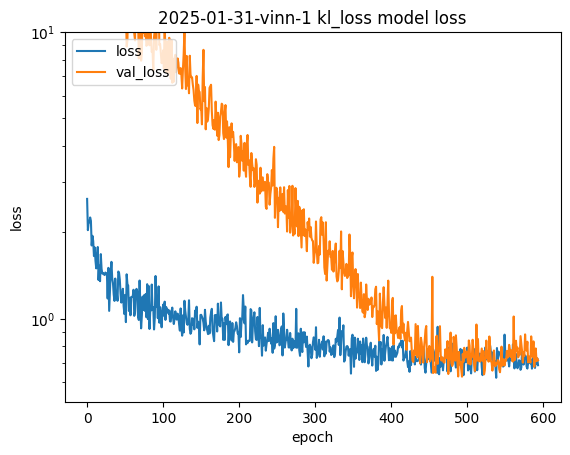

Val loss: 0.6268068552017212
Train loss: 0.7766131162643433
Test loss: 1.140204906463623
dO18 RMSE: 1.078082790002462


100%|██████████| 1024/1024 [01:43<00:00,  9.93it/s]


Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


In [56]:
EVAL_ONLY = False #@param{type:'boolean'}
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

# Optional Rendering

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

means_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=0)
raster.animate(means_isoscape,  1, 1)

Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


In [ ]:
vars_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=1)
raster.animate(vars_isoscape,  1, 1)